<a href="https://colab.research.google.com/github/hrbae/LG_AI_training/blob/main/M1_Proces_Innovationby_ML/Practice/Practical_1_3_Process_Remaining_Time_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader

from google.colab import drive

In [20]:
drive.mount('/content/gdriv')

Drive already mounted at /content/gdriv; to attempt to forcibly remount, call drive.mount("/content/gdriv", force_remount=True).


In [21]:
log = pd.read_csv('/content/gdriv/My Drive/lg실습/data/log.csv')
print(log.columns)
print(log.iloc[:5,:])

Index(['CONTAINER_NO', 'VESSEL', 'MCHN_ID', 'MCHN_TP_CD', 'JOB_TYPE',
       'FULL_EMPTY', 'BLOCK_BAY', 'JOB_END_DT'],
      dtype='object')
  CONTAINER_NO VESSEL MCHN_ID  ... FULL_EMPTY BLOCK_BAY        JOB_END_DT
0   container0  ship0   GC101  ...          M     2M-75   2018-01-31 9:49
1   container0  ship0   RS309  ...          M     2M-75   2018-01-31 9:55
2   container0  ship0   YT555  ...          M     2M-75   2018-01-31 9:54
3   container1  ship0   GC103  ...          F     3C-09  2018-01-31 10:50
4   container1  ship0   TC235  ...          F     3C-09  2018-01-31 10:58

[5 rows x 8 columns]


In [22]:
# 컨테이너 단위로 데이터 분리하여 잔여 시간
caseid = list(log['CONTAINER_NO'].value_counts().index)
dt = []
for i in caseid:
  sub_log = log.loc[log['CONTAINER_NO']==i,:]
  sub_log['JOB_END_DT'] = pd.to_datetime(sub_log['JOB_END_DT'])
  sub_log = sub_log.sort_values(by=['JOB_END_DT'])
  dt.append(sub_log.reset_index(drop=True))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [23]:
dt0 = []
for i in range(len(dt)):
  time = []
  for k in range(len(dt[i])):
    v = (pd.to_datetime(dt[i]['JOB_END_DT'][len(dt[i])-1]) - pd.to_datetime(dt[i]['JOB_END_DT'][k])).seconds/60
    time.append(v)
  dt0.append(pd.concat([dt[i],pd.DataFrame(time, columns = ['remain_time'])], axis = 1))

In [24]:
dt1 = dt0[0]
for i in range(1,len(dt0)):
  dt1 = dt1.append(dt0[i])

In [25]:
print(dt1.columns)

Index(['CONTAINER_NO', 'VESSEL', 'MCHN_ID', 'MCHN_TP_CD', 'JOB_TYPE',
       'FULL_EMPTY', 'BLOCK_BAY', 'JOB_END_DT', 'remain_time'],
      dtype='object')


In [26]:
job_type = pd.get_dummies(dt1['JOB_TYPE'])

dt = pd.concat([job_type, dt1['JOB_END_DT'], dt1['remain_time']], axis=1).reset_index(drop=True)
dt = dt.sort_values(by=['JOB_END_DT']).reset_index(drop=True)
print(dt)

       DS-MOVE  DS-QUAYSIDE  ...          JOB_END_DT  remain_time
0            0            1  ... 2018-01-16 09:16:00         13.0
1            0            1  ... 2018-01-16 09:18:00          7.0
2            0            1  ... 2018-01-16 09:18:00         12.0
3            0            1  ... 2018-01-16 09:18:00          5.0
4            0            1  ... 2018-01-16 09:19:00          7.0
...        ...          ...  ...                 ...          ...
34495        1            0  ... 2018-02-01 00:02:00          2.0
34496        0            0  ... 2018-02-01 00:02:00          0.0
34497        0            0  ... 2018-02-01 00:04:00          0.0
34498        1            0  ... 2018-02-01 00:05:00          1.0
34499        0            0  ... 2018-02-01 00:06:00          0.0

[34500 rows x 8 columns]


In [27]:
trainx = []
trainy = []
for i in range(700):
  x = dt.iloc[i:(i+100), :-2].values
  y = dt.iloc[i:(i+100), -1].values
  trainx.append(x)
  trainy.append(y)

testx = []
testy = []
for i in range(700, 1000):
  x = dt.iloc[i:(i+100), :-2].values
  y = dt.iloc[i:(i+100), -1].values
  testx.append(x)
  testy.append(y)



In [28]:
trainx = torch.FloatTensor(trainx).view(-1,1,100,6).cuda()
trainy = torch.FloatTensor(trainy).view(-1,100).cuda()

testx = torch.FloatTensor(testx).view(-1,1,100,6).cuda()
testy = torch.FloatTensor(testy).view(-1,100).cuda()

In [29]:
from torch.utils.data import DataLoader, TensorDataset
train_dataset=TensorDataset(trainx,  trainy)
test_dataset=TensorDataset(testx,  testy)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

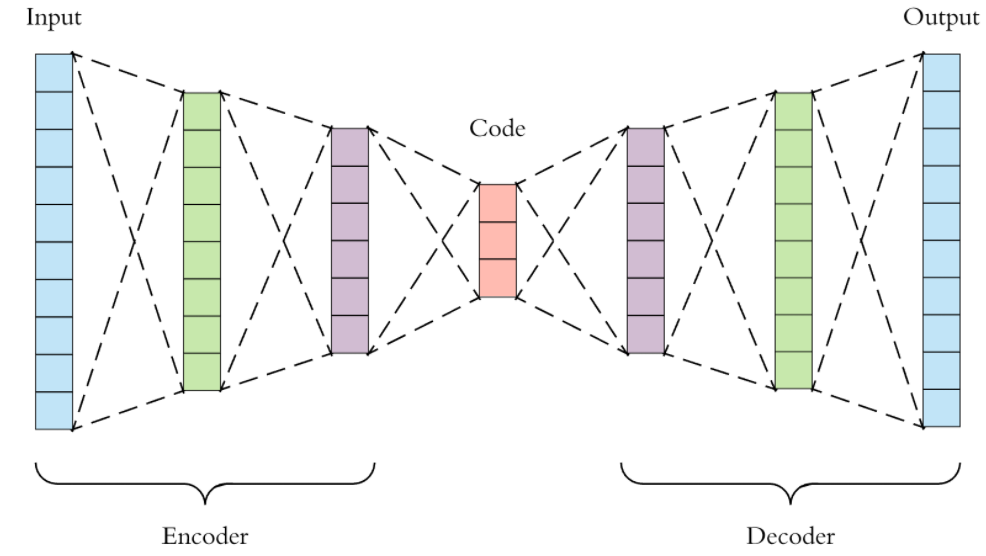

In [30]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 256, 3, stride=1, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1), 
            nn.Conv2d(256, 64, 3, stride=1, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1) 
        )
        self.decoder = nn.Sequential(
            nn.Linear(64*98*4,100), 
            nn.ReLU(True)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(-1,64*98*4)
        x = self.decoder(x)
        return x

In [31]:
model = autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.0001)

for epoch in range(100):
    train_loss = 0
    test_loss = []
    for x,y in train_loader:
        # ===================forward=====================
        output = model(x)
        loss = criterion(output,y)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    train_loss += loss.item()
    with torch.no_grad():
      for x,y in test_loader:
        output = model(x)
        loss = criterion(output,y)
        test_loss.append(loss.item())
    print('[Epoch {}/{}], [Train Loss: {}] [Test Loss: {}]'
          .format(epoch+1, 100, str(train_loss)[:4], str(np.mean(test_loss))[:4]))

[Epoch 1/100], [Train Loss: 38.8] [Test Loss: 40.9]
[Epoch 2/100], [Train Loss: 37.9] [Test Loss: 38.6]
[Epoch 3/100], [Train Loss: 33.5] [Test Loss: 34.9]
[Epoch 4/100], [Train Loss: 29.4] [Test Loss: 31.0]
[Epoch 5/100], [Train Loss: 21.7] [Test Loss: 28.1]
[Epoch 6/100], [Train Loss: 18.9] [Test Loss: 26.1]
[Epoch 7/100], [Train Loss: 17.2] [Test Loss: 24.5]
[Epoch 8/100], [Train Loss: 13.7] [Test Loss: 22.8]
[Epoch 9/100], [Train Loss: 12.6] [Test Loss: 21.9]
[Epoch 10/100], [Train Loss: 12.3] [Test Loss: 21.0]
[Epoch 11/100], [Train Loss: 9.75] [Test Loss: 20.5]
[Epoch 12/100], [Train Loss: 10.8] [Test Loss: 20.0]
[Epoch 13/100], [Train Loss: 9.24] [Test Loss: 19.4]
[Epoch 14/100], [Train Loss: 8.36] [Test Loss: 19.1]
[Epoch 15/100], [Train Loss: 7.51] [Test Loss: 18.8]
[Epoch 16/100], [Train Loss: 5.66] [Test Loss: 18.6]
[Epoch 17/100], [Train Loss: 5.58] [Test Loss: 18.4]
[Epoch 18/100], [Train Loss: 8.29] [Test Loss: 18.1]
[Epoch 19/100], [Train Loss: 7.02] [Test Loss: 17.9]
[E

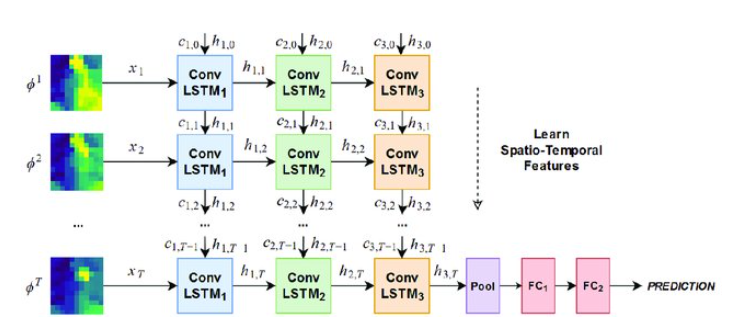

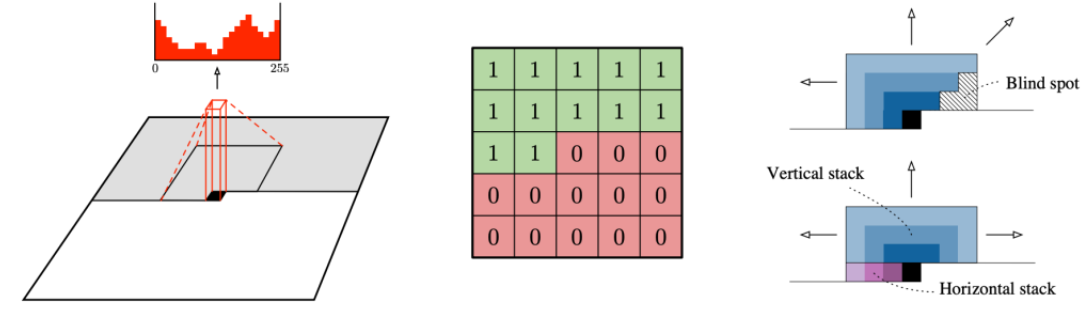

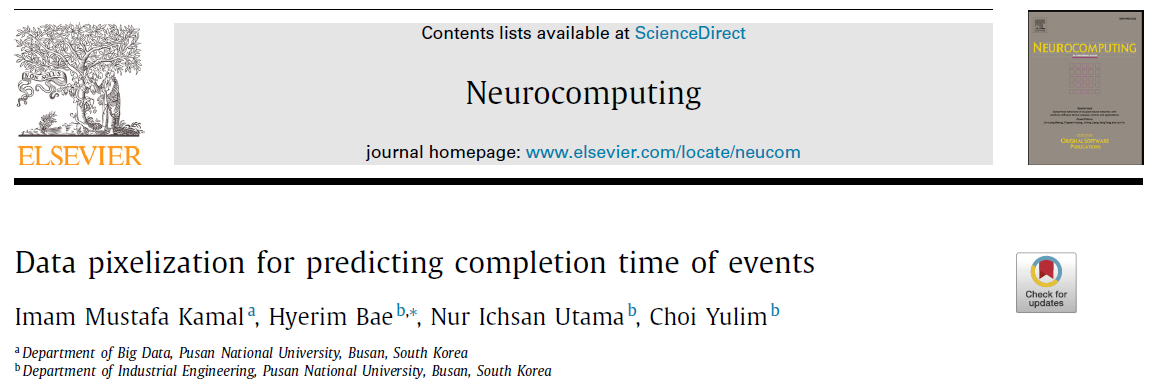

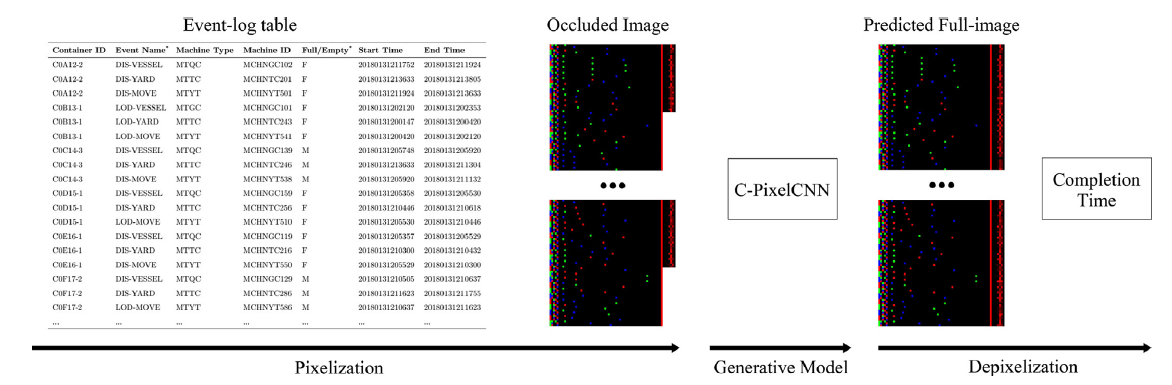

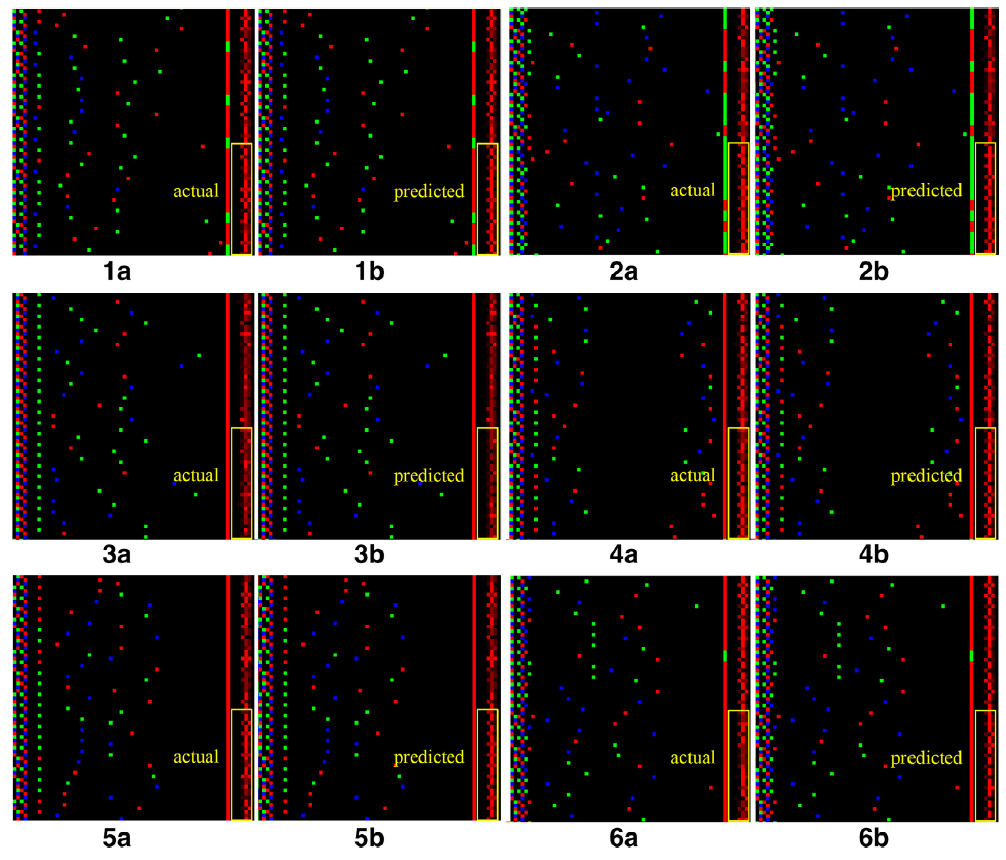

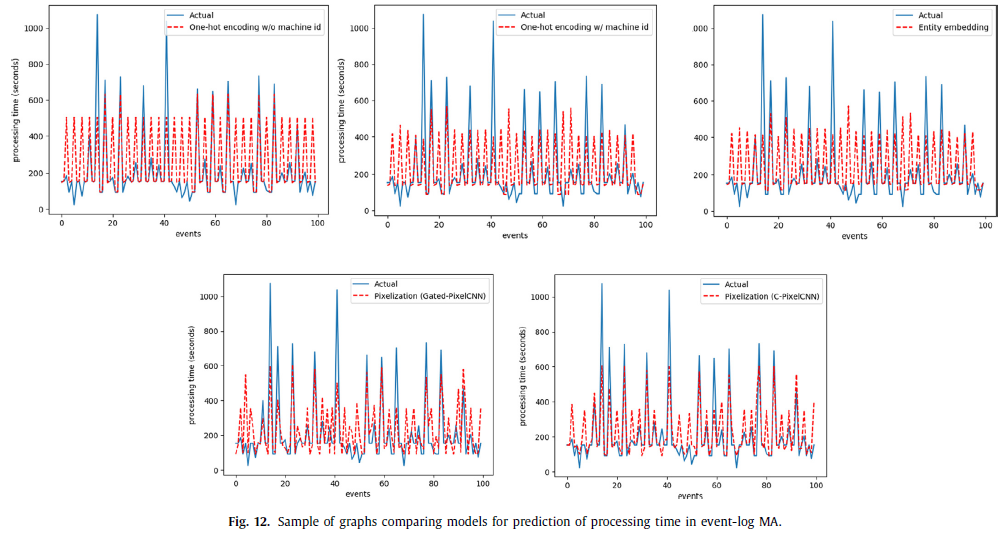